# Importing Libararies

In [3]:
import os
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from matplotlib.pyplot import imshow
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Looking into structure of file arrangements

In [4]:
for dirnames, _, filenames in os.walk('/kaggle/input/fruits-dataset-images/images/'):
    print(dirnames)
    if len(filenames) > 0:
        print(f'Contains {len(filenames)} number of files')
        print(filenames)

/kaggle/input/fruits-dataset-images/images/
/kaggle/input/fruits-dataset-images/images/apple fruit
Contains 40 number of files
['Image_22.jpg', 'Image_34.jpeg', 'Image_13.png', 'Image_4.jpg', 'Image_12.jpg', 'Image_16.jpg', 'Image_2.jpg', 'Image_7.jpg', 'Image_5.jpg', 'Image_28.png', 'Image_36.jpg', 'Image_18.jpg', 'Image_33.jpg', 'Image_19.jpg', 'Image_27.jpg', 'Image_11.jpg', 'Image_39.jpg', 'Image_26.jpg', 'Image_31.png', 'Image_10.jpg', 'Image_30.jpg', 'Image_23.png', 'Image_32.jpg', 'Image_21.jpg', 'Image_25.jpg', 'Image_15.jpg', 'Image_40.jpeg', 'Image_1.jpg', 'Image_35.jpg', 'Image_8.jpg', 'Image_38.jpg', 'Image_14.png', 'Image_20.jpg', 'Image_24.jpg', 'Image_29.jpg', 'Image_37.jpg', 'Image_6.jpg', 'Image_3.jpeg', 'Image_9.jpg', 'Image_17.jpeg']
/kaggle/input/fruits-dataset-images/images/orange fruit
Contains 40 number of files
['Image_22.jpg', 'Image_34.jpeg', 'Image_4.jpg', 'Image_12.jpg', 'Image_16.jpg', 'Image_2.jpg', 'Image_7.jpg', 'Image_5.jpg', 'Image_36.JPG', 'Image_18.j

In [26]:
shutil.copytree('/kaggle/input/fruits-dataset-images/images', '/kaggle/working/dataset')

'/kaggle/working/dataset'

In [28]:
DIR = '/kaggle/working/dataset'

In [31]:
files = os.listdir(DIR)
print(files)
class_count = len(files)
print(f'There are {class_count} car model classes.')

['strawberry fruit', 'kiwi fruit', 'chickoo fruit', 'cherry fruit', 'banana fruit', 'orange fruit', 'grapes fruit', 'apple fruit', 'mango fruit']
There are 9 car model classes.


In [32]:
# Remove Non JPG images
for cls in files:
    cls_path = os.path.join(DIR, cls)
    imgs =  os.listdir(cls_path)
    img = Image.open(os.path.join(cls_path,imgs[0]))
    print(f'Class {cls} contains {len(imgs)} images images of shape {img.size}.')
    for filees in imgs:
        if filees.endswith(('.jpg', '.jpeg')):
            None
        else:
            os.remove(os.path.join(cls_path,filees)) 
    print(f'Class {cls} contains {len(os.listdir(cls_path))} images of shape {img.size}.')

Class strawberry fruit contains 40 images images of shape (960, 638).
Class strawberry fruit contains 38 images of shape (960, 638).
Class kiwi fruit contains 40 images images of shape (1920, 1280).
Class kiwi fruit contains 37 images of shape (1920, 1280).
Class chickoo fruit contains 40 images images of shape (500, 500).
Class chickoo fruit contains 36 images of shape (500, 500).
Class cherry fruit contains 40 images images of shape (1024, 768).
Class cherry fruit contains 39 images of shape (1024, 768).
Class banana fruit contains 40 images images of shape (2228, 1883).
Class banana fruit contains 36 images of shape (2228, 1883).
Class orange fruit contains 40 images images of shape (1023, 993).
Class orange fruit contains 37 images of shape (1023, 993).
Class grapes fruit contains 40 images images of shape (2536, 3462).
Class grapes fruit contains 40 images of shape (2536, 3462).
Class apple fruit contains 40 images images of shape (640, 480).
Class apple fruit contains 35 images o

(900, 1200, 3)


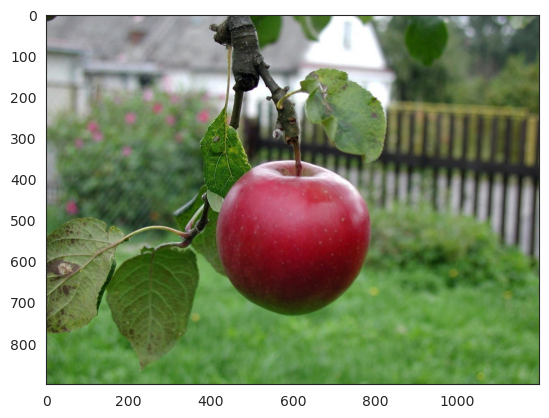

In [30]:
fpath=r'/kaggle/input/fruits-dataset-images/images/apple fruit/Image_22.jpg'
img=plt.imread(fpath)
print (img.shape)
imshow(img)

# Loading the dataset

In [73]:
filepaths=[]
labels=[]
classlist=os.listdir(DIR)
classlist.sort()
for klass in classlist:
    classpath=os.path.join(DIR, klass)
    flist=os.listdir(classpath)
    for f in flist:
        fpath=os.path.join(classpath,f)        
        filepaths.append(fpath)
        labels.append(klass)
    Fseries= pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels') 
    data_df=pd.concat([Fseries, Lseries], axis=1)
data_df = data_df.sample(frac=1)

# Data Visualization and Preprocessing

<AxesSubplot:title={'center':'Total Label Count Visualization'}, xlabel='labels', ylabel='count'>

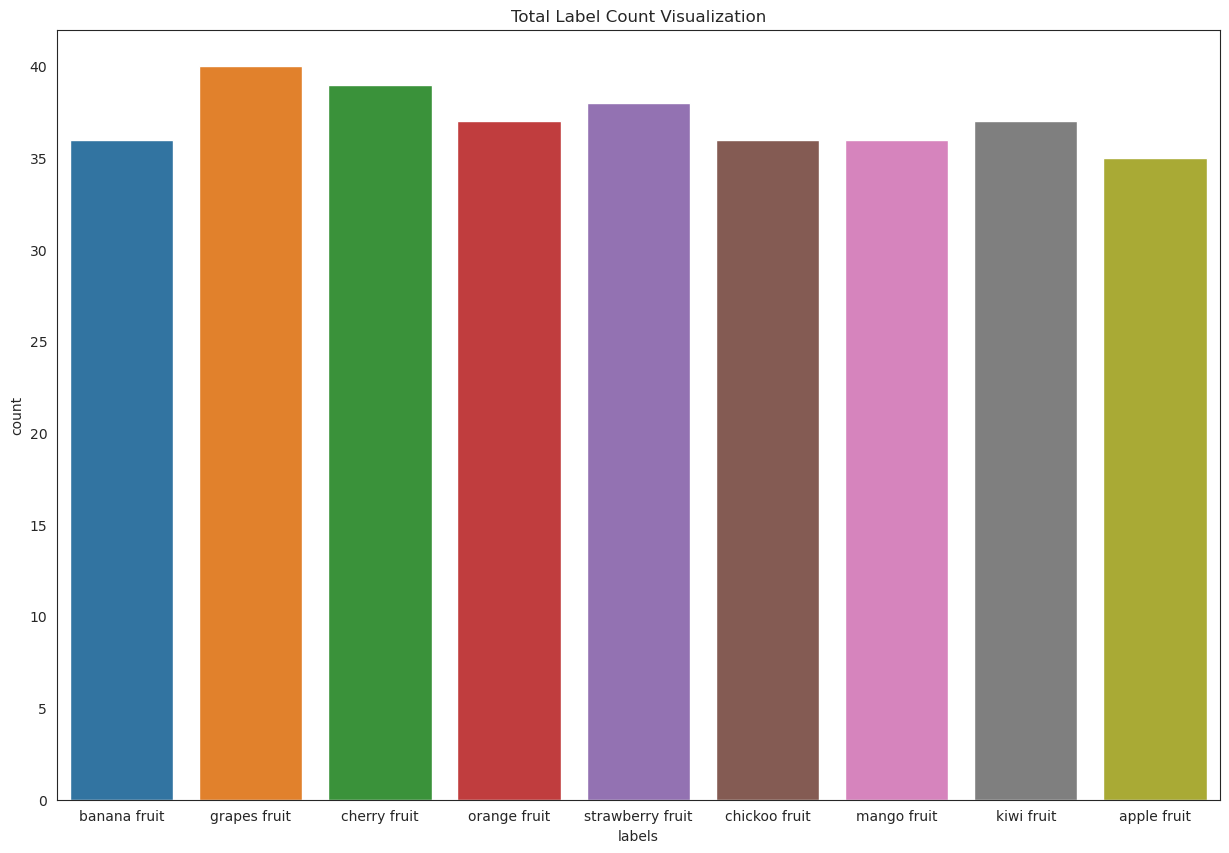

In [74]:
plt.figure(figsize = (15,10)) # Label Count
plt.title('Total Label Count Visualization')
sns.set_style("white")
sns.countplot(x=data_df['labels'], data=data_df)

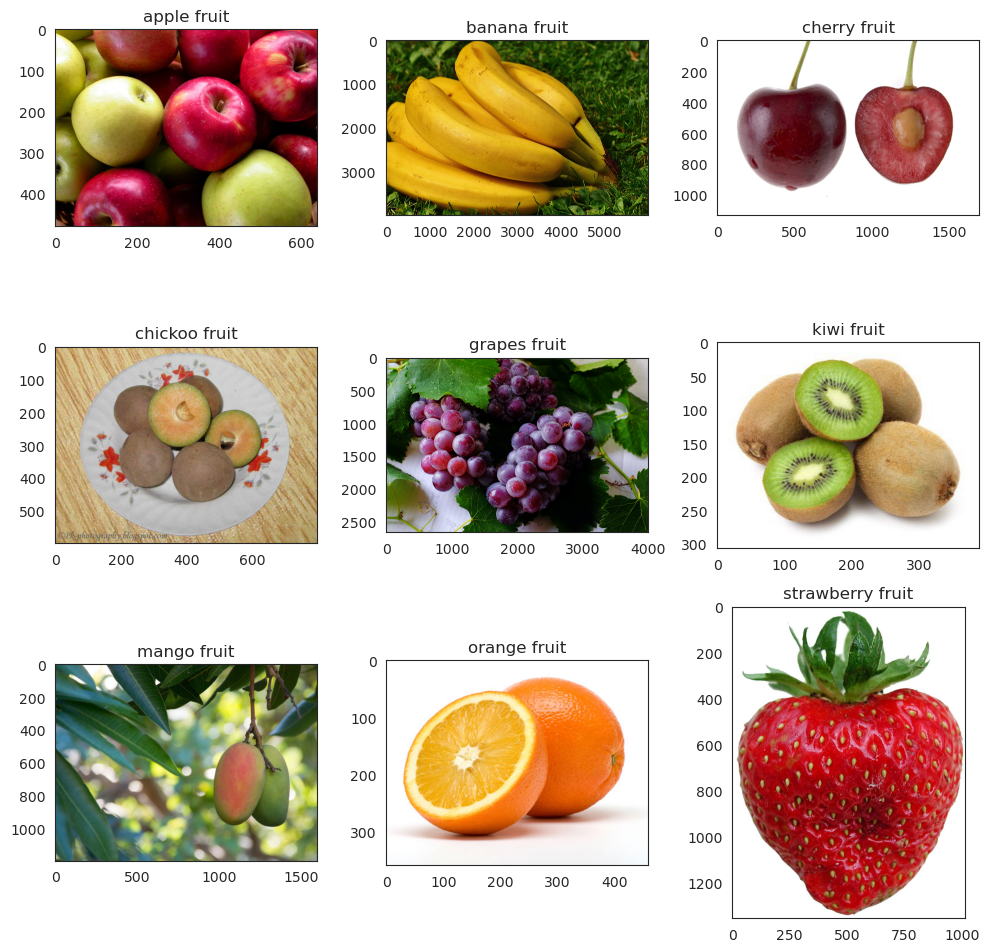

In [75]:
f, ax = plt.subplots(3,3) 
f.set_size_inches(10, 10)
k = 0
for i in range(3):
    for j in range(3):
        ax[i,j].set_title(data_df['labels'][k])
        img=plt.imread(data_df['filepaths'][k])
        ax[i,j].imshow(img)
        k += 40
    plt.tight_layout() 

# Creating the data generator using ImageDataGenerator for the CNN

In [78]:
def train_val_generators():
    """
    Creates the training and validation data generators
  
    Returns:
        train_generator, validation_generator - tuple containing the generators 
    """
    
    # Instantiate the ImageDataGenerator class ,normalize pixel values and set arguments to augment the images 
    datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       rotation_range=80,
                                       width_shift_range=0.1,
                                       height_shift_range=0.1,
                                       shear_range=0.1,
                                       zoom_range=0.1,
                                       horizontal_flip = True,
                                       vertical_flip = True,
                                       fill_mode='nearest',
                                       validation_split=0.1)
    # Pass in the appropriate arguments to the flow method
    train_generator = datagen.flow_from_dataframe(dataframe=data_df,
                                                        x_col="filepaths",
                                                        y_col="labels",
                                                        subset="training",
                                                        batch_size=32,
                                                        seed=42,
                                                        shuffle=True,
                                                        class_mode="categorical",
                                                        target_size=(150,150))
    
    # Pass in the appropriate arguments to the flow method
    validation_generator = datagen.flow_from_dataframe(dataframe=data_df,
                                                        x_col="filepaths",
                                                        y_col="labels",
                                                        subset="validation",
                                                        batch_size=16,
                                                        shuffle=False,
                                                        class_mode="categorical",
                                                        target_size=(150,150))
    return train_generator, validation_generator

In [79]:
train_generator, validation_generator = train_val_generators()

Found 301 validated image filenames belonging to 9 classes.
Found 33 validated image filenames belonging to 9 classes.


# Define and compile the model

In [81]:
def create_model():
    # Define the model
    # Use no more than 2 Conv2D and 2 MaxPooling2D
    model = tf.keras.models.Sequential([
          # This is the first convolution
          tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.MaxPooling2D(2, 2),
          # The second convolution
          tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.MaxPooling2D(2,2),
          tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.MaxPooling2D(2, 2),
          # Flatten the results to feed into a DNN
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(512, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(class_count, activation='softmax') 
          ])
  

    model.compile(loss = 'categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

    return model

In [82]:
# Instatentiate model
model = create_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 batch_normalization_9 (Batc  (None, 148, 148, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 64)        36928     
                                                                 
 batch_normalization_10 (Bat  (None, 72, 72, 64)       256       
 chNormalization)                                                
                                                      

# Creating a Callback class

In [83]:
class myCallback(tf.keras.callbacks.Callback):
    # Define the correct function signature for on_epoch_end
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy') is not None and logs.get('val_accuracy') == 1): 
            print(logs.get('val_accuracy'))
            print("\nReached 100% validation accuracy so cancelling training!")
callbacks = myCallback() 

In [84]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.25,   
    patience=2, 
    min_lr=1e-6,
    verbose=2
)

# Train the model

In [107]:
# Train the model
history = model.fit(train_generator,
                    epochs=25,
                    validation_data =validation_generator, 
                    callbacks=[callbacks, reduce_lr]
                   )

Epoch 1/25
10/10 [==============================] - 33s 3s/step - loss: 9.6396 - accuracy: 0.4352 - val_loss: 7.6863 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 2/25
10/10 [==============================] - 33s 3s/step - loss: 7.8422 - accuracy: 0.4086 - val_loss: 6.8118 - val_accuracy: 0.2121 - lr: 0.0010
Epoch 3/25
10/10 [==============================] - 33s 3s/step - loss: 6.3906 - accuracy: 0.4618 - val_loss: 12.5046 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 4/25
10/10 [==============================] - ETA: 0s - loss: 4.6417 - accuracy: 0.4950
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
10/10 [==============================] - 32s 3s/step - loss: 4.6417 - accuracy: 0.4950 - val_loss: 14.2958 - val_accuracy: 0.0606 - lr: 0.0010
Epoch 5/25
10/10 [==============================] - 32s 3s/step - loss: 3.0260 - accuracy: 0.5748 - val_loss: 15.6487 - val_accuracy: 0.1515 - lr: 2.5000e-04
Epoch 6/25
10/10 [==============================] - ETA: 0s - loss: 2

#  Evaluating Accuracy and Loss for the Model

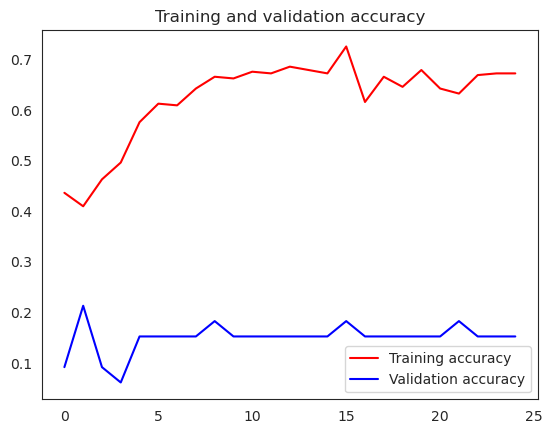

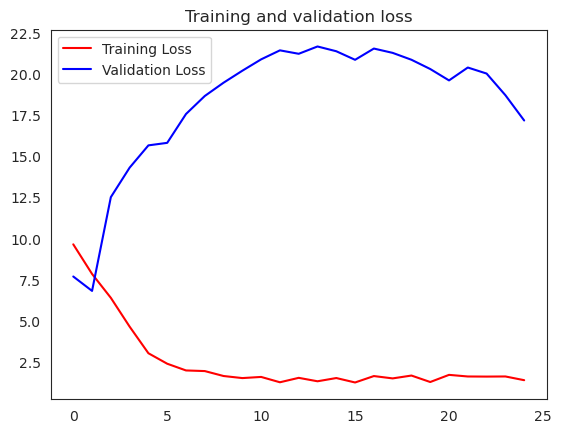

In [108]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [109]:
print("Accuracy of the model is - " , model.evaluate(validation_generator)[1]*100 , "%")

3/3 [==============================] - 2s 371ms/step - loss: 17.7266 - accuracy: 0.1818
Accuracy of the model is -  18.18181872367859 %


In [110]:
predictions = model.predict(validation_generator)
predictions=np.argmax(predictions,axis=-1)
predictions 

3/3 [==============================] - 2s 356ms/step


array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3,
       3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3])

#  Evaluating  Precision, Recall, F1-Score and Support for the Model

In [113]:
dict_cls = validation_generator.class_indices

In [114]:
print(dict_cls)

{'apple fruit': 0, 'banana fruit': 1, 'cherry fruit': 2, 'chickoo fruit': 3, 'grapes fruit': 4, 'kiwi fruit': 5, 'mango fruit': 6, 'orange fruit': 7, 'strawberry fruit': 8}


In [116]:
print(classification_report(validation_generator.labels, predictions, target_names = list(dict_cls.keys())))

                  precision    recall  f1-score   support

     apple fruit       0.00      0.00      0.00         2
    banana fruit       0.50      0.33      0.40         3
    cherry fruit       0.00      0.00      0.00         5
   chickoo fruit       0.16      1.00      0.28         5
    grapes fruit       0.00      0.00      0.00         1
      kiwi fruit       0.00      0.00      0.00         5
     mango fruit       0.00      0.00      0.00         2
    orange fruit       0.00      0.00      0.00         5
strawberry fruit       0.00      0.00      0.00         5

        accuracy                           0.18        33
       macro avg       0.07      0.15      0.08        33
    weighted avg       0.07      0.18      0.08        33



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Plotting the Confusion Matrix for the Classification

<AxesSubplot:>

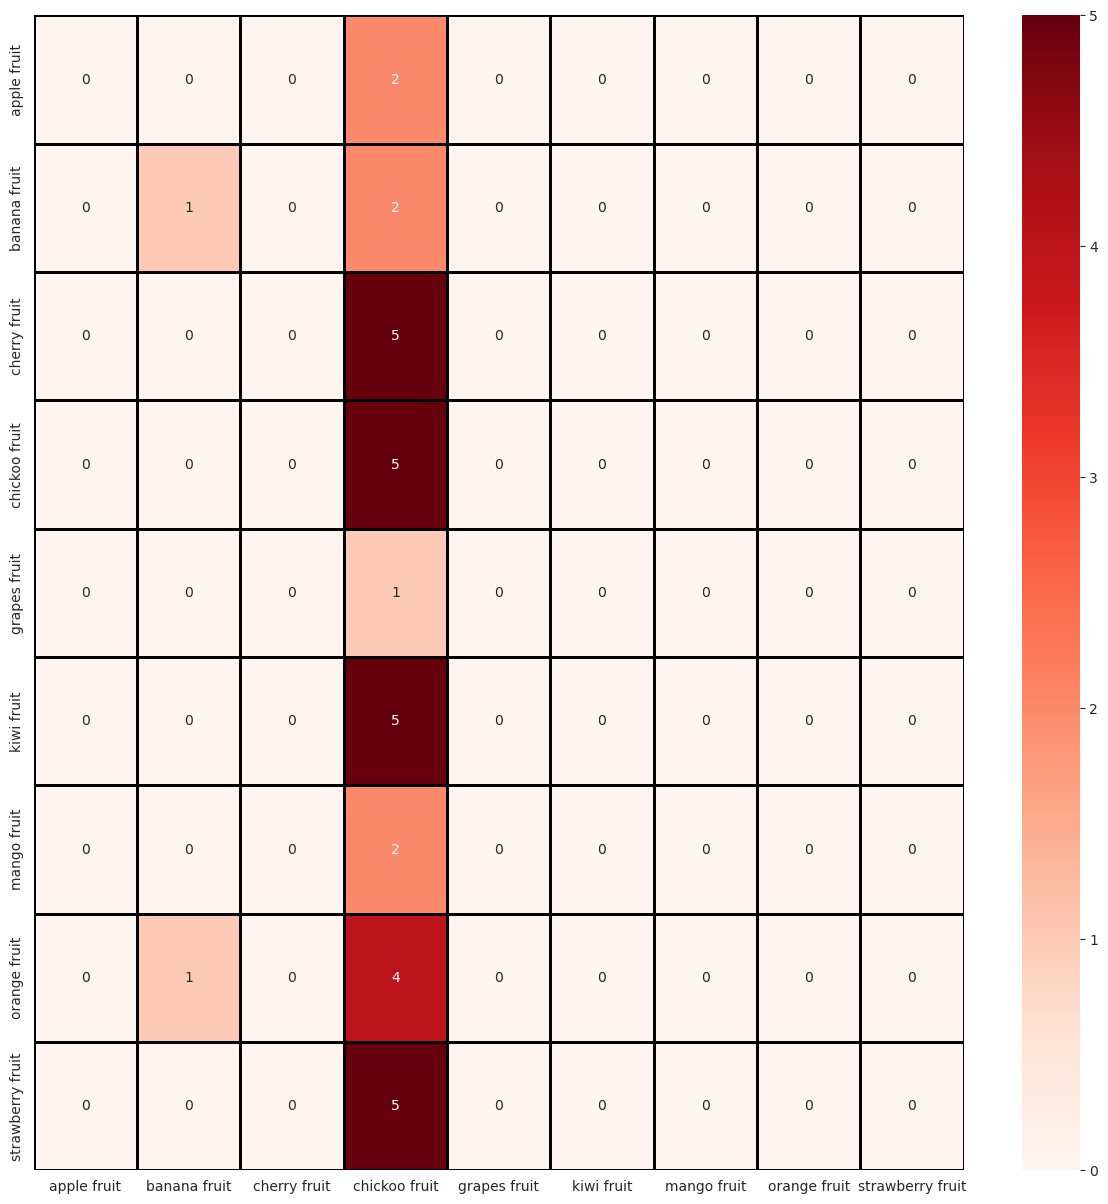

In [117]:
cm = confusion_matrix(validation_generator.labels,predictions)
cm = pd.DataFrame(cm , index = list(dict_cls.keys()) , columns = list(dict_cls.keys()))
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Reds", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [118]:
def class_name(id):
    key_list = list(dict_cls.keys())
    val_list = list(dict_cls.values())
    position = val_list.index(id)
    return key_list[position]

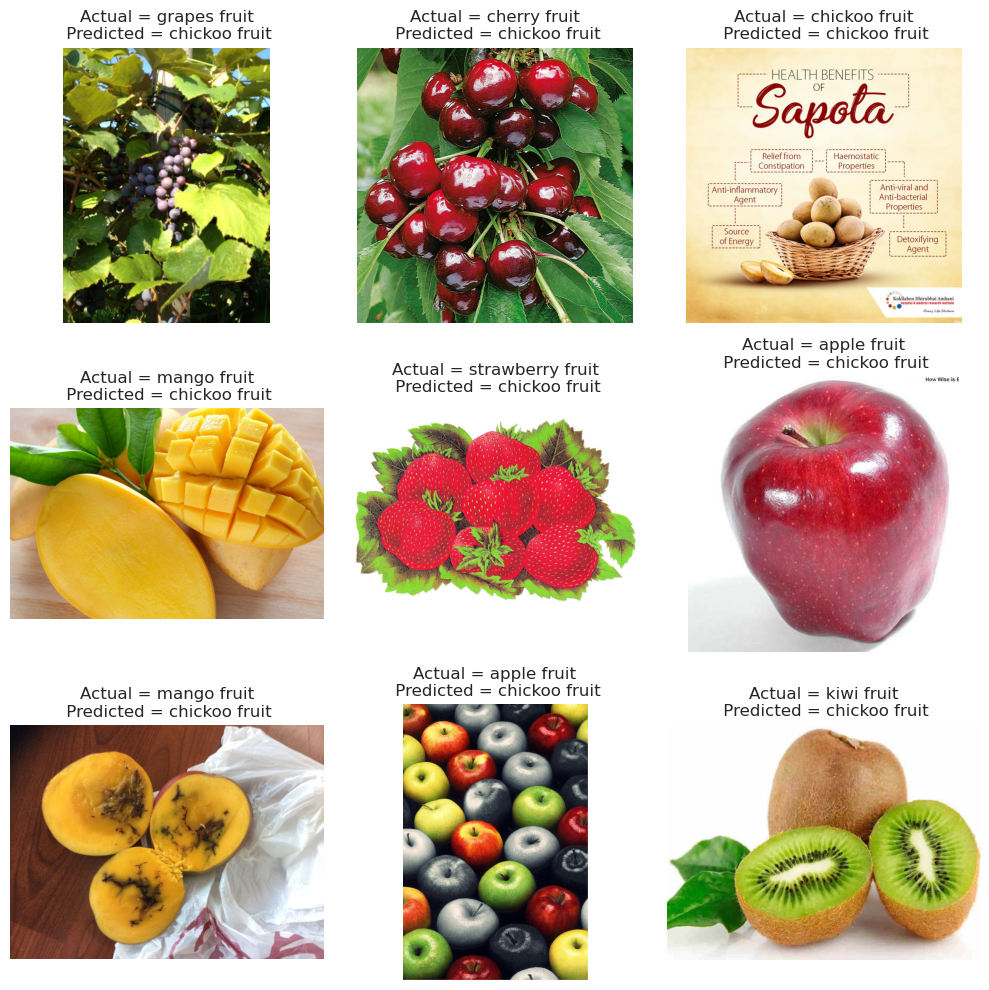

In [119]:
f, ax = plt.subplots(3,3) 
f.set_size_inches(10, 10)
k = 1
for i in range(3):
    for j in range(3):
        true_cls = validation_generator.labels[k]
        true_cls = class_name(true_cls)
        pred_cls = predictions[k]
        pred_cls = class_name(pred_cls)
        ax[i,j].set_title(f'Actual = {true_cls}\n Predicted = {pred_cls}')
        img=plt.imread(validation_generator.filenames[k])
        ax[i,j].imshow(img)
        ax[i,j].axis('off')
        k += 3
    
    plt.tight_layout() 